In [17]:
import sys
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter
import polars as pl

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def to_human(num, suffix="B"):
    if num % 1024 != 0:
        return f"{num}{suffix}"
    else:
        return pretty_fmt(num, suffix)

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="rdbench-ior"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png', 'eps'):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 

In [18]:
def load_ior_summary_list(json_file: Path):
    try:
        # print(json_file)
        data = json.loads(json_file.read_text())
        return [
            {
                'Version': data['Version'],
                'Began': data['Began'],
                'Command line': data['Command line'],
                'Machine': data['Machine'],
                'Finished': data['Finished'],
                **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
                # **{f"max_{k}": v for k, v in test["max"].items()},
                **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
                **{f"Options_{k}": v for k, v in test["Options"].items()},
                **{f'summary_{k}': v for k, v in data['summary'][index].items()},
                **{f'result_{k}': v for k, v in result.items()},
                # 'iorIteration': iteration,
            }
            for index, test in enumerate(data['tests'])
            for result in test["Results"]
            # for iteration, results in enumerate(test["Results"]) # iteration ?
            # for result in results
        ]
    except Exception as e:
        print(f"Failed to load {json_file}, {e}")
        return []

In [19]:
RAW_BASEDIR = Path(f"../../raw/")

default_metadata = {}

# fmt: off
job_group = (
    ("rdbench-ior-peanuts/2024.10.04-14.33.46-default", {}),
    ("rdbench-ior-peanuts/2024.10.04-15.11.35-default", {}),
)
# fmt: on

re_timestamp = re.compile(
    r"([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})"
)


def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None


re_runid = re.compile(r"_([0-9]+)\.json")


def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None


def load_job_params(job_dir: Path, runid: int):
    try:
        return json.loads((job_dir / f"job_params_{runid}.json").read_text())
    except Exception as e:
        print(f"Failed to load job_params{runid}.json, {e}")
        return {}


df_src = (
    pl.DataFrame(
        [
            {
                **default_metadata,
                "job_start": parse_job_start_timestamp(job_dir),
                **load_job_params(job_dir, get_runid(ior_summary_file)),
                **ior_summary,
                **metadata,
            }
            for job_group_dir, metadata in job_group
            for job_dir in (RAW_BASEDIR / job_group_dir).glob("*")
            if job_dir.is_dir()
            for ior_summary_file in job_dir.glob("ior_summary_*.json")
            for ior_summary in load_ior_summary_list(ior_summary_file)
        ]
    )
    .with_columns(
        odirect=pl.col("Command line").str.contains("--posix.odirect"),
        strided=pl.col("summary_transferSize") == pl.col("summary_blockSize"),
    )
    .rename(
        {
            "summary_bwMaxMIB": "bw",
            "summary_MeanTime": "time",
            "summary_segmentCount": "segmentCount",
            "summary_blockSize": "blockSize",
            "summary_transferSize": "transferSize",
            "summary_operation": "operation",
            "Parameters_filePerProc": "fpp",
            "Parameters_reorderTasks": "reorder",
            "summary_API": "api",
            "result_access": "access",
            "result_bwMiB": "bwMiB",
            "result_openTime": "openTime",
            "result_wrRdTime": "wrRdTime",
            "result_closeTime": "closeTime",
            "result_totalTime": "totalTime",
        }
    )
    .with_columns(
        fpp=pl.col("fpp").cast(pl.Boolean),
        reorder=pl.col("reorder").cast(pl.Boolean),
        bwGB=pl.col("bwMiB") * 2**20 / 10**9,
    )
    .with_columns(
        pl.when((pl.col("storageSystem") == "PEANUTS") & (pl.col("spack_env_name") == "mpiio-pmembb"))
        .then(True)
        .otherwise(False)
        .alias("aggread")
    )
)

In [20]:
(
    df_src
    .select(
        "runid",
        "storageSystem",
        "aggread",
        # "access",
        "nnodes",
        # "transferSize",
        "bwGB",
        "openTime",
        "wrRdTime",
        "closeTime",
    )
    # .filter(pl.col("transferSize") == 2*2**20, pl.col("access") == "read")
    # .filter(pl.col("storageSystem") == "PMEMBB", pl.col("lustre_stripe_count") != 1)
)

runid,storageSystem,aggread,nnodes,bwGB,openTime,wrRdTime,closeTime
i64,str,bool,i64,f64,f64,f64,f64
1,"""PEANUTS""",true,16,170.675748,1.5581,0.2528,0.0011
2,"""PEANUTS""",true,16,1038.975867,0.0439,0.2529,0.0011
1,"""PEANUTS""",true,49,158.263456,5.4252,0.558,0.0018
2,"""PEANUTS""",true,49,1460.447002,0.0909,0.5569,0.0019
1,"""PEANUTS""",true,64,159.437421,7.2549,0.5,0.0048
…,…,…,…,…,…,…,…
2,"""PEANUTS""",false,25,1178.278305,0.0254,0.3837,0.0014
1,"""PEANUTS""",true,64,154.930133,7.4244,0.5598,0.0031
2,"""PEANUTS""",true,64,2052.863609,0.035,0.5646,0.0064


In [21]:
NETWORK_LIMIT_PER_NODE = 200 / 8
PMEM_READ_LIMIT_PER_NODE = 80.309346 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 25.836094 * 2**30 / 10**9

print(f"PMEM_READ_LIMIT_PER_NODE: {PMEM_READ_LIMIT_PER_NODE} GB/s")
print(f"PMEM_WRITE_LIMIT_PER_NODE: {PMEM_WRITE_LIMIT_PER_NODE} GB/s")
print(f"NETWORK_LIMIT_PER_NODE: {NETWORK_LIMIT_PER_NODE} GB/s")

def network_limit(nnodes):
    return nnodes * NETWORK_LIMIT_PER_NODE

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE

PMEM_READ_LIMIT_PER_NODE: 86.23150365828711 GB/s
PMEM_WRITE_LIMIT_PER_NODE: 27.741294696595457 GB/s
NETWORK_LIMIT_PER_NODE: 25.0 GB/s


1st open


nnodes,PEANUTS +optim,PEANUTS
i64,f64,f64
1,61.351417,61.263138
4,136.619225,136.099245
9,170.239374,170.030527
16,170.675748,172.075828
25,164.851992,162.90525
36,169.272442,168.889296
49,158.263456,156.484994
64,159.437421,154.536917


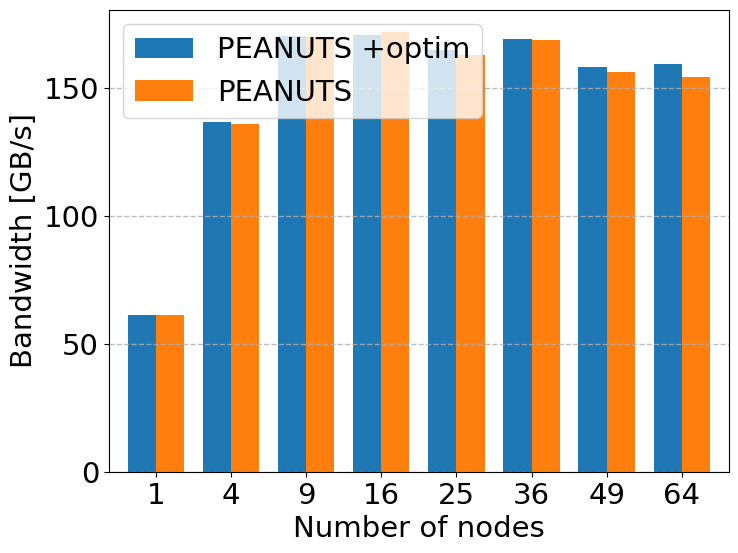

2nd open


nnodes,PEANUTS +optim,PEANUTS
i64,f64,f64
1,78.619568,77.723462
4,300.531881,296.992037
9,645.265634,644.313983
16,1038.975867,1148.186892
25,1181.093041,1178.278305
36,2290.016226,2395.366552
49,1570.00353,1518.435206
64,2237.479556,1901.538


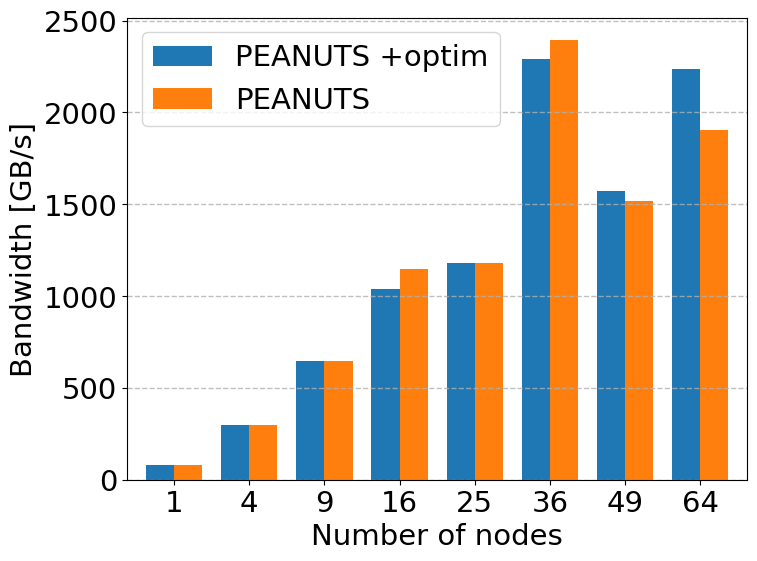

In [22]:
group_by_columns = [
    "storageSystem",
    "aggread",
    "access",
    "nnodes",
    "runid",
    # "bwGB",
    # "openTime",
    # "wrRdTime",
    # "closeTime",
]
df = (
    df_src.lazy()
    .filter(
        pl.col("access") == "read",
    )
    .group_by(group_by_columns)
    .agg(
        pl.max("bwGB"),
        pl.min("openTime"),
        pl.min("wrRdTime"),
        pl.min("closeTime"),
    )
    .with_columns(
        pl.when((pl.col("storageSystem") == "PEANUTS") & (pl.col("aggread")))
        .then(pl.lit("PEANUTS +optim"))
        .otherwise(pl.col("storageSystem"))
        .alias("legend")
    )
    .sort("nnodes")
    .collect()
)
# display(df)

for (runid,),df_sub in df.group_by("runid"):
    fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    print("1st open" if runid == 1 else "2nd open")
    # display(df_sub)
    (
        df_sub
        .pivot(values="bwGB", index="nnodes", on="legend")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes,
            kind="bar",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    axes.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
    plt.show()

storageSystem,aggread,access,nnodes,runid,bwGB,openTime,wrRdTime,closeTime,legend
str,bool,str,i64,i64,f64,f64,f64,f64,str
"""PEANUTS""",true,"""read""",1,1,61.351417,0.0742,0.2382,0.0008,"""PEANUTS +optim"""
"""PEANUTS""",true,"""read""",1,2,78.619568,0.0051,0.2403,0.0004,"""PEANUTS +optim"""
"""PEANUTS""",false,"""read""",1,2,77.723462,0.0047,0.2424,0.0004,"""PEANUTS"""
"""PEANUTS""",false,"""read""",1,1,61.263138,0.0738,0.2413,0.0004,"""PEANUTS"""
"""PEANUTS""",false,"""read""",4,1,136.099245,0.319,0.2479,0.0005,"""PEANUTS"""
…,…,…,…,…,…,…,…,…,…
"""PEANUTS""",true,"""read""",49,1,158.263456,5.4252,0.558,0.0018,"""PEANUTS +optim"""
"""PEANUTS""",true,"""read""",64,1,159.437421,7.2549,0.5,0.0031,"""PEANUTS +optim"""
"""PEANUTS""",true,"""read""",64,2,2237.479556,0.035,0.5024,0.0053,"""PEANUTS +optim"""


PEANUTS +optim 2


nnodes,openTime,wrRdTime,closeTime
i64,f64,f64,f64
1,0.0051,0.2403,0.0004
4,0.0114,0.2449,0.001
9,0.0163,0.2526,0.001
16,0.0439,0.2511,0.0011
25,0.0466,0.3618,0.0011
36,0.0539,0.2486,0.0033
49,0.0457,0.5569,0.0019
64,0.035,0.5024,0.0053


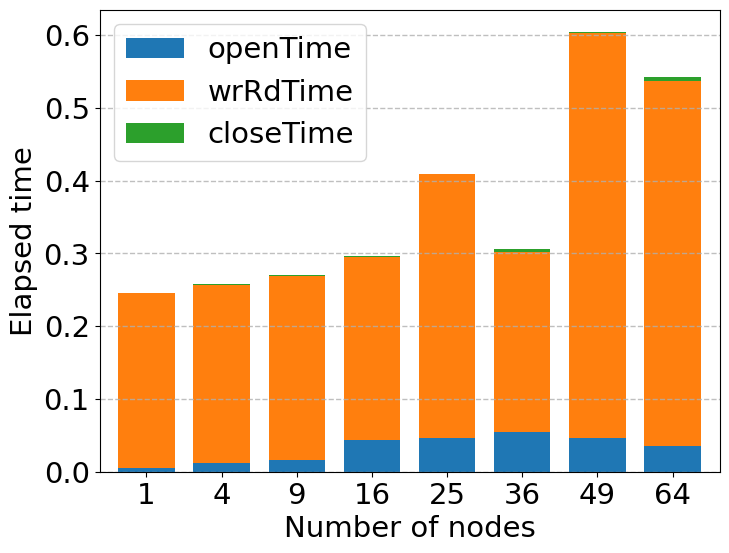

PEANUTS +optim 1


nnodes,openTime,wrRdTime,closeTime
i64,f64,f64,f64
1,0.0742,0.2382,0.0008
4,0.3178,0.2441,0.0005
9,0.7714,0.2464,0.0009
16,1.5581,0.2527,0.0011
25,2.5683,0.3615,0.0015
36,3.8629,0.2482,0.0024
49,5.4252,0.558,0.0018
64,7.2549,0.5,0.0031


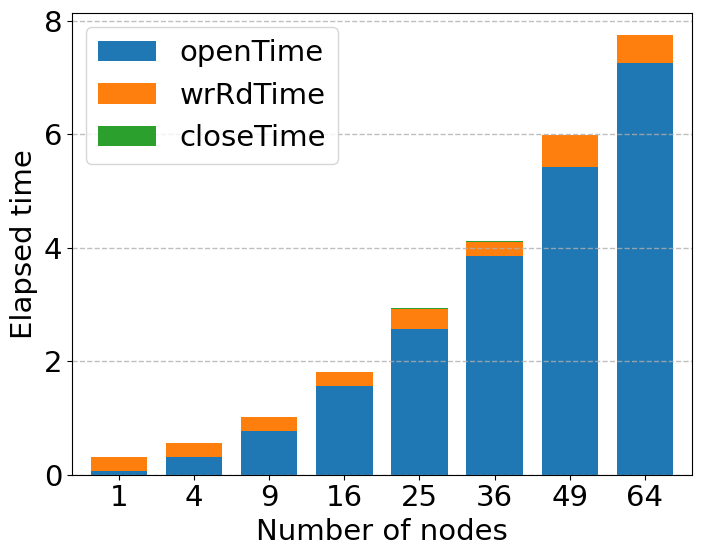

PEANUTS 2


nnodes,openTime,wrRdTime,closeTime
i64,f64,f64,f64
1,0.0047,0.2424,0.0004
4,0.0108,0.2466,0.0005
9,0.0139,0.2493,0.0008
16,0.0179,0.2491,0.0026
25,0.0254,0.3836,0.0014
36,0.0412,0.2499,0.0019
49,0.0443,0.5765,0.0035
64,0.0883,0.5598,0.0039


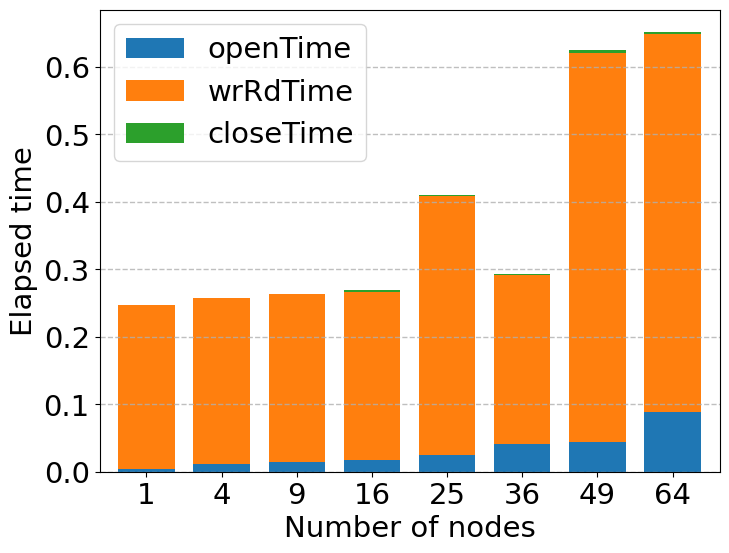

PEANUTS 1


nnodes,openTime,wrRdTime,closeTime
i64,f64,f64,f64
1,0.0738,0.2413,0.0004
4,0.319,0.2479,0.0005
9,0.7719,0.2474,0.0009
16,1.5475,0.2497,0.0011
25,2.581,0.3839,0.0016
36,3.8701,0.249,0.0019
49,5.4749,0.5752,0.0018
64,7.4392,0.5633,0.0026


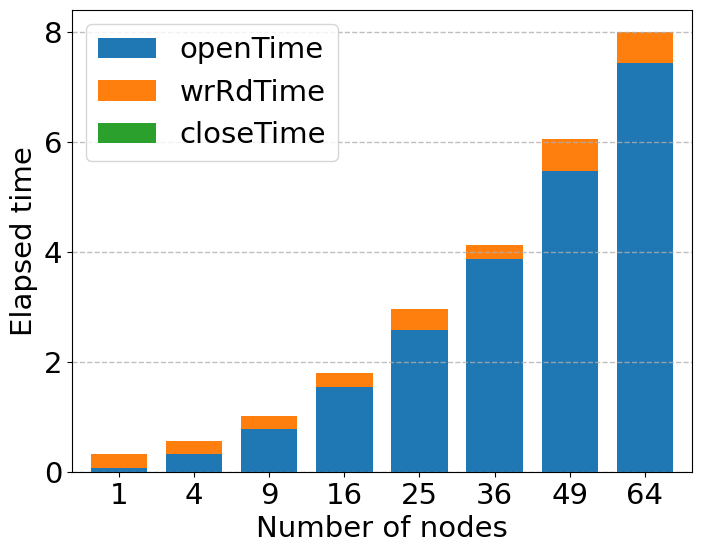

In [23]:
display(df)

for (legend,runid),df_sub in df.group_by("legend", "runid"):
    fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    print(legend, runid)
    # display(df_sub)
    (
        df_sub
        .select(
            "nnodes",
            "openTime",
            "wrRdTime",
            "closeTime",
        )
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes,
            kind="bar",
            stacked=True,
            xlabel="Number of nodes",
            ylabel="Elapsed time",
            rot=0,
            width=0.75,
        )
    )
    axes.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
    plt.show()

In [24]:
plt.rcParams.update({"font.size": 21})

group_by_columns = [
    "storageSystem",
    "aggread",
    "access",
    "nnodes",
]
df = (
    df_src.lazy()
    .filter(
        pl.col("access") == "read",
    )
    .group_by(group_by_columns + ["transferSize"])
    .agg(pl.max("bwGB"))
    .collect()
)
display(df)


for (access, remote), df_sub in df.group_by(("access", "reorder")):
    print(access, remote)

    ylim=(0, df_sub.select(pl.max("bwGB")).item())

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)
    fig.patch.set_alpha(1)
    ax0 = (
        df_sub.group_by(group_by_columns)
        .agg(pl.max("bwGB"))
        .pivot(values="bwGB", index="nnodes", columns="storageSystem")
        .rename({"PMEMBB": "PEANUTS"})
        .select(["nnodes", "Lustre", "BeeOND", "CHFS", "UnifyFS", "PEANUTS"])
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[0],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax0.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    ax0.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)

    ax1 = (
        df_sub.filter(pl.col("storageSystem") == "PMEMBB")
        .with_columns(
            transferSizeH=pl.col("transferSize").map_elements(to_human, pl.String),
        )
        .sort(["nnodes", "transferSize"])
        .pivot(values="bwGB", index="nnodes", columns="transferSizeH")
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[1],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax1.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)
    # ax1.set_ylim(ax0.get_ylim())
    # ax0.set_ylim(ylim)
    # ax1.set_ylim(ylim)

    nnode_list = [int(t.get_text()) for t in ax0.get_xaxis().get_ticklabels()]
    if access == "write":
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": pmem_write_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "blue",
                "linestyle": "--",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit", linewidth=2)
        # ax1.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
        ax0.set_ylim(0, pmem_write_limit(nnode_list[-1]) * 1.05)
    else:
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": network_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "green",
                "linestyle": "-.",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.set_ylim(0, network_limit(nnode_list[-1]) * 1.05)
        if not remote:
            for xtick, nnodes in enumerate(nnode_list):
                hline_params = {
                    "y": pmem_read_limit(nnodes),
                    "xmin": (xtick + 0.01) / len(nnode_list),
                    "xmax": (xtick + 0.85) / len(nnode_list),
                    "color": "red",
                    "linestyle": ":",
                    "linewidth": 2,
                }
                ax0.axhline(**hline_params)
                ax1.axhline(**hline_params)
            ax0.plot([], [], linestyle=":", color="red", label="PMEM Read Limit", linewidth=2)
            # ax1.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
            ax0.set_ylim(0, pmem_read_limit(nnode_list[-1]) * 1.05)
        ax0.plot([], [], linestyle="-.", color="green", label="Network Limit", linewidth=2)
        # ax1.plot([], [], linestyle="-.", color="green", label="Network Limit")

    ax1.set_ylim(ax0.get_ylim())
    ax0.legend(title="", fontsize=20)
    ax1.legend(title="", fontsize=18, ncols=2)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    plt.show()
    save(fig, f"ior_bw_{access}_{'remote' if remote else 'local'}_wide")

storageSystem,aggread,access,nnodes,transferSize,bwGB
str,bool,str,i64,i64,f64
"""PEANUTS""",false,"""read""",16,2097152,1148.186892
"""PEANUTS""",true,"""read""",36,2097152,2290.016226
"""PEANUTS""",true,"""read""",25,2097152,1181.093041
"""PEANUTS""",true,"""read""",49,2097152,1570.00353
"""PEANUTS""",true,"""read""",1,2097152,78.619568
…,…,…,…,…,…
"""PEANUTS""",false,"""read""",49,2097152,1518.435206
"""PEANUTS""",false,"""read""",36,2097152,2395.366552
"""PEANUTS""",false,"""read""",4,2097152,296.992037


ColumnNotFoundError: reorder